### Курсовая работа

Задание по итогам курса

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

*(Усложненное задание) Все тоже самое, но воспользоваться этим датасетом:
https://fitnessallyapp.com/datasets/jester/v1

!pip install opencv-python

In [ ]:
import cv2
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

import os
import csv
import glob
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

from PIL import Image

Из большого датасета возьму только несколько классов

In [ ]:
LABELS = {
    "Swiping Right": 0,
    "Swiping Left": 1,
    "No gesture": 2,
    "Thumb Up": 3,
}

### Отрисовка всех классов

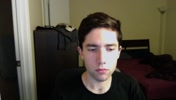

KeyboardInterrupt: 

In [ ]:
from IPython import display
from IPython.display import HTML

images = os.listdir(BASE_PATH + '/20bn-jester-v1/136859/')
images2 = os.listdir(BASE_PATH + '/20bn-jester-v1/68574/')
images3 = os.listdir(BASE_PATH + '/20bn-jester-v1/20706/')
images4 = os.listdir(BASE_PATH + '/20bn-jester-v1/62818/')

while True:
    for f in images:
        display.clear_output(wait=True)
        display.display(Image(filename=BASE_PATH + '/20bn-jester-v1/136859/'+f))
        display.display(HTML('<h3>Thumb Up</h3>'))
        time.sleep(0.1)
    for f in images2:
        display.clear_output(wait=True)
        display.display(Image(filename=BASE_PATH + '/20bn-jester-v1/68574/'+f))
        display.display(HTML('<h3>Swiping Right</h3>'))
        time.sleep(0.1)
    for f in images3:
        display.clear_output(wait=True)
        display.display(Image(filename=BASE_PATH + '/20bn-jester-v1/20706/'+f))
        display.display(HTML('<h3>No gesture</h3>'))
        time.sleep(0.1)
    for f in images4:
        display.clear_output(wait=True)
        display.display(Image(filename=BASE_PATH + '/20bn-jester-v1/62818/'+f))
        display.display(HTML('<h3>Swiping Left</h3>'))
        time.sleep(0.1)

In [ ]:
from collections import namedtuple

ListDataJpeg = namedtuple('ListDataJpeg', ['id', 'label', 'path'])

class JpegDataset(object):

    def __init__(self, csv_path_input, csv_path_labels, data_root):
        self.classes = self.read_csv_labels(csv_path_labels)
        self.classes_dict = self.get_two_way_dict(self.classes)
        self.csv_data = self.read_csv_input(csv_path_input, data_root)

    def read_csv_input(self, csv_path, data_root):
        csv_data = []
        with open(csv_path) as csvfile:
            csv_reader = csv.reader(csvfile, delimiter=';')
            for row in csv_reader:
                item = ListDataJpeg(row[0],
                                    row[1],
                                    os.path.join(data_root, row[0])
                                    )
                if row[1] in self.classes:
                    csv_data.append(item)
        return csv_data

    def read_csv_labels(self, csv_path):
        classes = []
        with open(csv_path) as csvfile:
            csv_reader = csv.reader(csvfile)
            for row in csv_reader:
                classes.append(row[0])
        return classes

    def get_two_way_dict(self, classes):
        classes_dict = {}
        for i, item in enumerate(classes):
            classes_dict[item] = i
            classes_dict[i] = item
        return classes_dict

In [ ]:
IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG']


def default_loader(path):
    return Image.open(path).convert('RGB')


class VideoFolder(torch.utils.data.Dataset):

    def __init__(self, root, csv_file_input, csv_file_labels, clip_size,
                 nclips, step_size, is_val, transform=None,
                 loader=default_loader):
        self.dataset_object = JpegDataset(csv_file_input, csv_file_labels, root)

        self.csv_data = self.dataset_object.csv_data
        self.classes = self.dataset_object.classes
        self.classes_dict = self.dataset_object.classes_dict
        self.root = root
        self.transform = transform
        self.loader = loader

        self.clip_size = clip_size
        self.nclips = nclips
        self.step_size = step_size
        self.is_val = is_val

    def __getitem__(self, index):
        item = self.csv_data[index]
        img_paths = self.get_frame_names(item.path)

        imgs = []
        for img_path in img_paths:
            img = self.loader(img_path)
            img = self.transform(img)
            imgs.append(torch.unsqueeze(img, 0))

        target_idx = self.classes_dict[item.label]

        # format data to torch
        data = torch.cat(imgs)
        data = data.permute(1, 0, 2, 3)
        return (data, target_idx)

    def __len__(self):
        return len(self.csv_data)

    def get_frame_names(self, path):
        frame_names = []
        for ext in IMG_EXTENSIONS:
            frame_names.extend(glob.glob(os.path.join(path, "*" + ext)))
        frame_names = list(sorted(frame_names))
        num_frames = len(frame_names)

        # set number of necessary frames
        if self.nclips > -1:
            num_frames_necessary = self.clip_size * self.nclips * self.step_size
        else:
            num_frames_necessary = num_frames

        # pick frames
        offset = 0
        if num_frames_necessary > num_frames:
            # pad last frame if video is shorter than necessary
            frame_names += [frame_names[-1]] * (num_frames_necessary - num_frames)
        elif num_frames_necessary < num_frames:
            # If there are more frames, then sample starting offset
            diff = (num_frames - num_frames_necessary)
            # Temporal augmentation
            if not self.is_val:
                offset = np.random.randint(0, diff)
        frame_names = frame_names[offset:num_frames_necessary +
                                  offset:self.step_size]
        return frame_names

transform = Compose([
                        CenterCrop(84),
                        ToTensor(),
                        # Normalize(
                        #     mean=[0.485, 0.456, 0.406],
                        #     std=[0.229, 0.224, 0.225])
                        ])
loader = VideoFolder(root="/hdd/20bn-datasets/20bn-jester-v1/",
                         csv_file_input="csv_files/jester-v1-validation.csv",
                         csv_file_labels="csv_files/jester-v1-labels.csv",
                         clip_size=18,
                         nclips=1,
                         step_size=2,
                         is_val=False,
                         transform=transform,
                         loader=default_loader)
    # data_item, target_idx = loader[0]
    # save_images_for_debug("input_images", data_item.unsqueeze(0))

train_loader = torch.utils.data.DataLoader(
        loader,
        batch_size=10, shuffle=False,
        num_workers=5, pin_memory=True)

In [ ]:
transform = tt.Compose([
        tt.CenterCrop(84),
        tt.ToTensor(),
        tt.Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
    ])

In [ ]:
train_data = VideoFolder(root="./data/20bn-jester-v1-short",
                             csv_file_input='./data/jester-v1-train-short.csv',
                             csv_file_labels="./data/jester-v1-labels-short.csv",
                             clip_size=18,
                             nclips=1,
                             step_size=2,
                             is_val=False,
                             transform=transform,
                             )
train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=10, shuffle=True,
        num_workers=0, pin_memory=True,
        drop_last=True)

In [ ]:
len(train_loader)

1689

In [ ]:
val_data = VideoFolder(root="./data/20bn-jester-v1-short",
                           csv_file_input="./data/jester-v1-validation-short.csv",
                           csv_file_labels="./data/jester-v1-labels-short.csv",
                           clip_size=18,
                           nclips=1,
                           step_size=2,
                           is_val=True,
                           transform=transform,
                           )

val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=10, shuffle=False,
        num_workers=0, pin_memory=True,
        drop_last=False)

In [ ]:
class ConvColumn(nn.Module):

    def __init__(self, num_classes):
        super(ConvColumn, self).__init__()

        self.conv_layer1 = self._make_conv_layer(3, 64, (1, 2, 2), (1, 2, 2))
        self.conv_layer2 = self._make_conv_layer(64, 128, (2, 2, 2), (2, 2, 2))
        self.conv_layer3 = self._make_conv_layer(
            128, 256, (2, 2, 2), (2, 2, 2))
        self.conv_layer4 = self._make_conv_layer(
            256, 256, (2, 2, 2), (2, 2, 2))

        self.fc5 = nn.Linear(12800, 512)
        self.fc5_act = nn.ELU()
        self.fc6 = nn.Linear(512, num_classes)

    def _make_conv_layer(self, in_c, out_c, pool_size, stride):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_c),
            nn.ELU(),
            nn.MaxPool3d(pool_size, stride=stride, padding=0)
        )
        return conv_layer

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)

        x = x.view(x.size(0), -1)

        x = self.fc5(x)
        x = self.fc5_act(x)

        x = self.fc6(x)
        return x

In [ ]:
device = torch.device('cpu')

In [ ]:
model = ConvColumn(27)
model

ConvColumn(
  (conv_layer1): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
#define optimizer
epochs = 50
max_lr = 0.008
lr = 0.001
last_lr = 0.00001
momentum = 0.9
weight_decay = 0.00001
optimizer = torch.optim.SGD(model.parameters(), lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

epochs = 50
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

1.6.0


for batch_idx, (data, labels) in enumerate(train_loader):
    pass

In [ ]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = Variable(data), Variable(labels)
        #data = data.cuda()
        #labels = labels.cuda()
        
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 100 == 99:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/100}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Train Epoch: 1, Loss: 1.6060215157270432
Spend time for 10000 images: 2025.9248452186584 sec


In [ ]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [ ]:
torch.save(model.state_dict(), './models/proba.pth')